# Dogs vs cats using fastai

In [1]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate

In [4]:
path = Config.data_path(); path

PosixPath('/root/.fastai/data')

In [0]:
path = '/root/.fastai/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -f train.zip

 99% 537M/544M [00:08<00:00, 72.8MB/s]
100% 544M/544M [00:08<00:00, 64.6MB/s]


In [8]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -f test.zip

 97% 264M/271M [00:04<00:00, 83.3MB/s]
100% 271M/271M [00:04<00:00, 64.1MB/s]


In [0]:
!unzip train.zip

In [0]:
!rm train.zip test.zip

In [12]:
!ls /root/.fastai/data

test  train


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [14]:
path = Config.data_path(); path

PosixPath('/root/.fastai/data')

In [15]:
path.ls()

[PosixPath('/root/.fastai/data/train'), PosixPath('/root/.fastai/data/test')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [16]:
fnames = get_image_files(path/'train')
fnames[:5]

[PosixPath('/root/.fastai/data/train/dog.8911.jpg'),
 PosixPath('/root/.fastai/data/train/dog.10434.jpg'),
 PosixPath('/root/.fastai/data/train/cat.1368.jpg'),
 PosixPath('/root/.fastai/data/train/dog.4335.jpg'),
 PosixPath('/root/.fastai/data/train/cat.4786.jpg')]

In [0]:
np.random.seed(2019)
pat = r'/([^/]+)\.\d+\.jpg$'

In [18]:
%%time
#https://docs.fast.ai/data_block.html
src = (ImageList.from_folder(path/'train')
       .random_split_by_pct(0.1)
       .label_from_re(pat))

data = (src.transform(get_transforms(), size=224)
        .add_test_folder('../test')
        .databunch(bs=bs).normalize(imagenet_stats))

CPU times: user 1.66 s, sys: 160 ms, total: 1.82 s
Wall time: 1.86 s


In [0]:
data.train_ds

LabelList (22500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,dog,dog,cat
Path: /root/.fastai/data/train

In [0]:
data.valid_ds

LabelList (2500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dog,dog,dog,dog,dog
Path: /root/.fastai/data/train

In [0]:
data.test_ds

LabelList (12500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/train

CPU times: user 2.76 s, sys: 1.25 s, total: 4.01 s
Wall time: 8.16 s


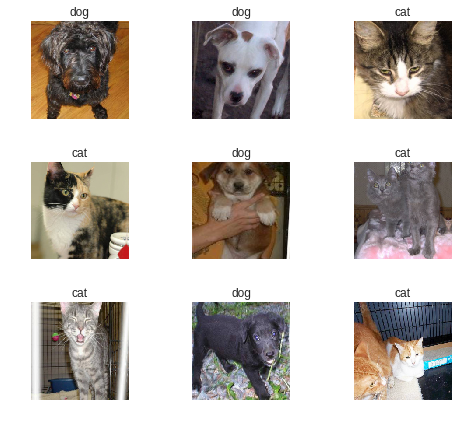

In [0]:
%%time
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
data.c, len(data.train_ds), len(data.valid_ds)

['cat', 'dog']


(2, 22500, 2500)

The testset order is significant for predictions outputs for kaggle submission. The order in data.test_ds is the same as os.listdir.

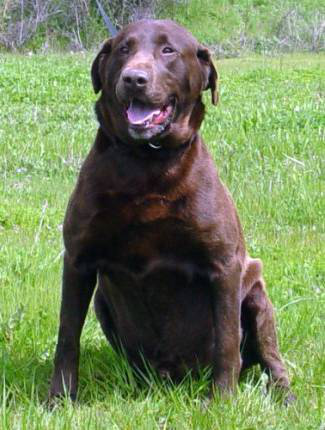

In [0]:
im = open_image('./test/'+os.listdir('./test')[10225])
im

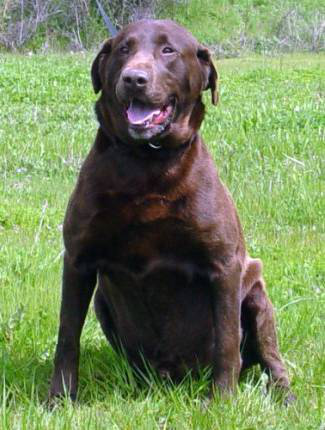

In [0]:
data.test_ds.x[10225]

In [0]:
msk = np.argsort([int(f.split('.')[0]) for f in os.listdir('./test')])

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [20]:
# docs https://docs.fast.ai/vision.learner.html#create_cnn
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.model_dir = '/content/drive/My Drive/DL_projects/catsdogs'

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 88291053.85it/s]


In [0]:
# model architecture
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 56, 56]      0          False     
______________________________________________________________

In [0]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 14.4 s, sys: 8.81 s, total: 23.2 s
Wall time: 1min 37s


Min numerical gradient: 1.45E-03


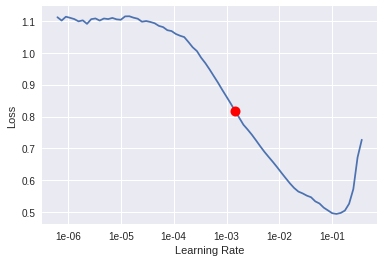

In [0]:
learn.recorder.plot()

In [0]:
# exp 1
learn.fit_one_cycle(4, max_lr=slice(5e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate
1,0.065297,0.028871,0.010800
2,0.046036,0.023325,0.008400
3,0.033104,0.026118,0.008400
4,0.030207,0.019983,0.006800


Better model found at epoch 1 with val_loss value: 0.0288712065666914.
Better model found at epoch 2 with val_loss value: 0.023324862122535706.
Better model found at epoch 4 with val_loss value: 0.019982535392045975.


In [0]:
# exp 2
learn.fit_one_cycle(5, max_lr=slice(5e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate
1,0.061994,0.038339,0.014000
2,0.049276,0.033946,0.009600
3,0.036215,0.028601,0.009200
4,0.031818,0.026703,0.009200
5,0.024681,0.021922,0.007600


Better model found at epoch 1 with val_loss value: 0.03833916410803795.
Better model found at epoch 2 with val_loss value: 0.03394630551338196.
Better model found at epoch 3 with val_loss value: 0.028601031750440598.
Better model found at epoch 4 with val_loss value: 0.026703400537371635.
Better model found at epoch 5 with val_loss value: 0.021922098472714424.


In [0]:
# exp 3
learn.fit_one_cycle(6, max_lr=slice(5e-3), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate
1,0.078275,0.036329,0.014800
2,0.060366,0.026660,0.010400
3,0.038491,0.026890,0.008800
4,0.032324,0.017824,0.006000
5,0.032305,0.018827,0.007600
6,0.020748,0.017723,0.006800


Better model found at epoch 1 with val_loss value: 0.036329399794340134.
Better model found at epoch 2 with val_loss value: 0.026659997180104256.
Better model found at epoch 4 with val_loss value: 0.017823755741119385.
Better model found at epoch 6 with val_loss value: 0.017723077908158302.


In [0]:
# exp 4
learn.fit_one_cycle(7, max_lr=slice(5e-3))

epoch,train_loss,valid_loss,error_rate
1,0.071486,0.039122,0.013600
2,0.061857,0.024555,0.010000
3,0.046672,0.022987,0.009600
4,0.033517,0.019754,0.007200
5,0.024878,0.019511,0.007200
6,0.027444,0.021505,0.006800
7,0.020628,0.018228,0.008000


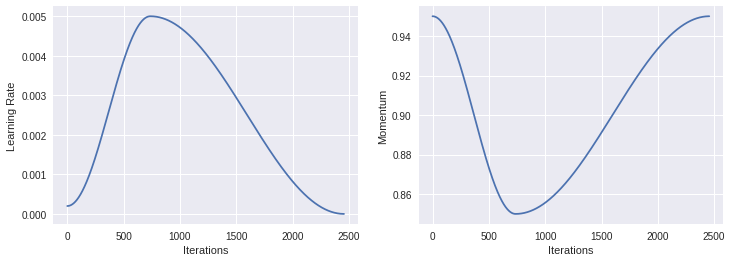

In [0]:
learn.recorder.plot_lr(show_moms=True)

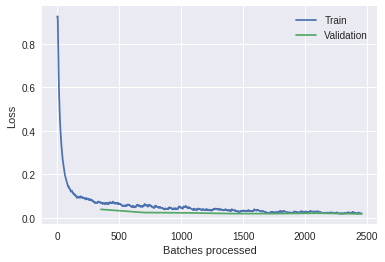

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1')

In [0]:
# test set prediction
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [29]:
# test time augmentation
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
preds = preds[msk]

In [0]:
submit = pd.DataFrame({'id':np.arange(len(preds))+1, 'label':preds[:,1].numpy()})
submit.to_csv('/content/drive/My Drive/DL_projects/catsdogs/submit.csv', index=False)

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/catsdogs')

In [33]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submit.csv -m "fastai resnet34 stage-1 with 4 epochs and TTA"

100% 204k/204k [00:08<00:00, 23.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

In [0]:
os.chdir('/root/.fastai/data')

In [0]:
learn.load('stage-1');

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

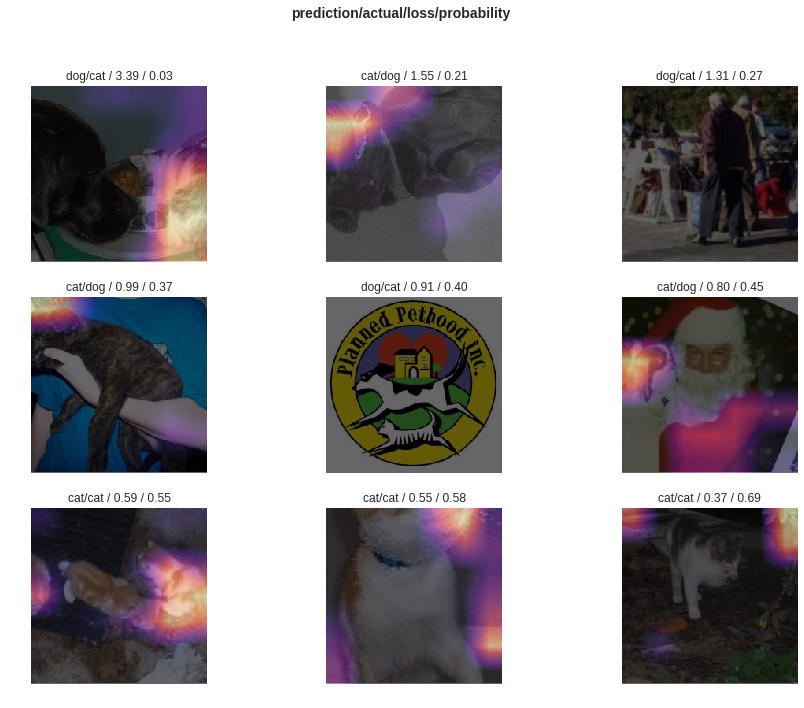

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

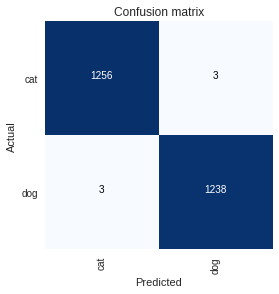

In [0]:
interp.plot_confusion_matrix()

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
# unfreeze all of the weights of the whole network
learn.unfreeze()

In [0]:
learn.load('stage-1-6epochs');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07


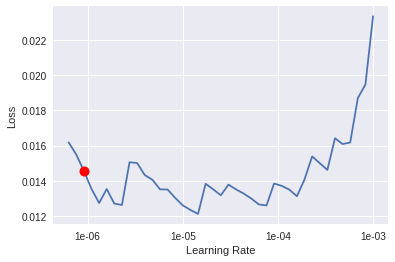

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5), callbacks=[SaveModelCallback(learn, name='stage-2-2epochs')])

epoch,train_loss,valid_loss,error_rate,time
1,0.025312,0.006549,0.003600,06:21
2,0.022772,0.006830,0.002800,06:23


Better model found at epoch 1 with val_loss value: 0.006548551842570305.


In [0]:
learn.save('stage-2')

In [0]:
# test set prediction
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [72]:
# test time augmentation
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
preds = preds[msk]

In [0]:
submit = pd.DataFrame({'id':np.arange(len(preds))+1, 'label':preds[:,1].numpy()})
submit.to_csv('/content/drive/My Drive/DL_projects/catsdogs/submit.csv', index=False)

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/catsdogs')

In [76]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submit.csv -m "fastai resnet34 stage-2 with 2 epochs and TTA"

100% 204k/204k [00:14<00:00, 14.4kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

In [0]:
os.chdir('/root/.fastai/data')

In [0]:
learn.load('stage-2');